# Students-courses graph

From a small anonymous liberal arts college, actual enrollment for the Fall 2020 semester.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# Read the data

filename = '../../data/courses.xls'

dfd = pd.read_excel(filename, sheet_name=None) # Read all pages in a dict, in a horrible format
names = [df.iloc[0,1] + ' - ' + df.iloc[2,1].split(' ')[0] for key,df in dfd.items()]
# Names will be course name + last name of the professor
# (As for some courses we have several sections, and no obvious id to distinguish them)

dfd = pd.read_excel(filename, sheet_name=None, header=10) # Read all pages in a dict, in a good format
i = 0
for key,val in dfd.items():
    val['course'] = names[i]
    if i == 0:
        df = val
    else:
        df = pd.concat((df, val), axis=0)
    i += 1
    
df.columns = ['N', 'id', 'Student', 'Area', 'Group', 'Course']
df = df.drop(['Student','Area','Group'], axis=1) # Drop names and extra info

In [3]:
G = nx.Graph()
node_type = {}
for i in range(df.shape[0]):
    course = df.Course.iloc[i]
    id = df.id.iloc[i]
    node_type[course] = 0
    node_type[id] = 1
    G.add_node(course)
    G.add_node(id)
    G.add_edge(course, id)

In [4]:
nodes = list(G.nodes())
node_color = []
for i in range(len(nodes)):
    if node_type[nodes[i]]==0: # A course: mark it red
        node_color.append((1,0,0))
    else:
        node_color.append((0,0,0)) # A student: mark them black

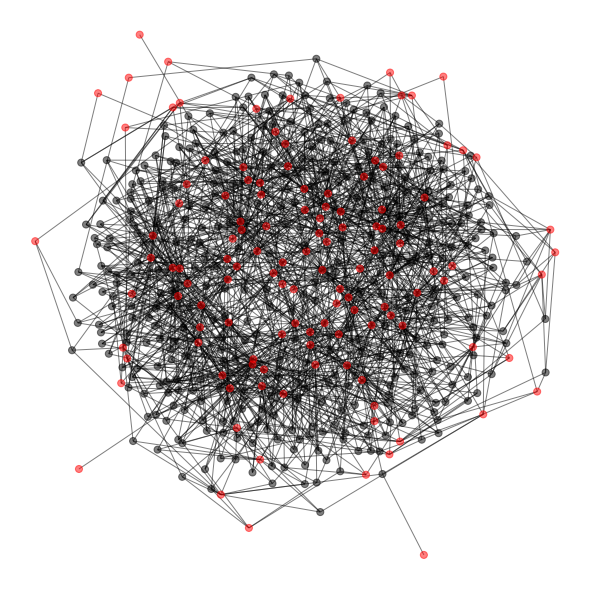

In [5]:
plt.figure(figsize=(8,8))
nx.draw_kamada_kawai(G, node_size=50, alpha=0.5, node_color=node_color)

In [31]:
# Output graph for future analysis

node_names = list(G.nodes)
node_nums = {node_names[i]:i for i in range(len(node_names))}
out_types = [node_type[name] for name in node_names]
edges = [tuple(node_nums[name] for name in edge) for edge in G.edges]

f = open("college_graph.txt", "w")
f.write('Edges:\n')
f.write(str(edges))
f.write('\n\nTypes (0 for course, 1 for student):\n')
f.write(str(out_types))
f.close()

# Simple stats

### How many students are met by every student?

In [6]:
# Condense the graph from bipartite to simple

gdict = nx.to_dict_of_dicts(G) # Output back to base data structure

for k,v in gdict.items():
    gdict[k] = list(v.keys()) # Go from dict-of-dicts to dict-of-lists (kill node properties)

In [17]:
# Now remove red nodes (courses) by connecting students direction

def bipartite_to_simple(gdict, node_type):
    """Converts a bipartite course-student graph into weighted student-student graph."""
    gdict_new = {}
    for student,courses in gdict.items():
        if node_type[student] == 1: # If actually student
            gdict_new[student] = list(set((other for course in courses 
                                                     for other in gdict[course]
                                                         if other != student)))
            # Not that list(set()) oparation removes duplicates
    return gdict_new

gdict_simple = bipartite_to_simple(gdict, node_type)

Mean: 59.18848167539267, median: 60.0


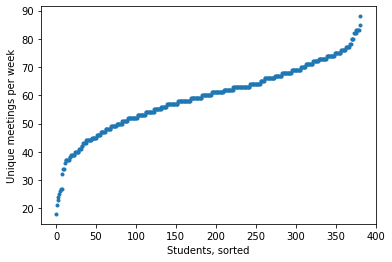

In [18]:
# Count friends
y = np.array([len(v) for k,v in gdict_simple.items()])

plt.plot(np.sort(y),'.');
plt.xlabel('Students, sorted');
plt.ylabel('Unique meetings per week');

print(f"Mean: {np.mean(y)}, median: {np.median(y)}")

# How to identify most dangerous courses

**Betweenness centrality** is slow to calculate, but it is theoretically best thing to use in this case:

* [Communicability betweenness centrality](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.communicability_betweenness_centrality.html#networkx.algorithms.centrality.communicability_betweenness_centrality)

References:

* Ernesto Estrada, Desmond J. Higham, Naomichi Hatano, “Communicability Betweenness in Complex Networks” Physica A 388 (2009) 764-774. https://arxiv.org/abs/0905.4102
* Magelinski, T., Bartulovic, M., & Carley, K. M. (2020). Modularity-Impact: a Signed Group Centrality Measure for Complex Networks. arXiv preprint arXiv:2003.00056.

In [12]:
cent = nx.communicability_betweenness_centrality(G)
cent = sorted([(v,a) for a,v in cent.items() if node_type[a]==0], reverse=True)

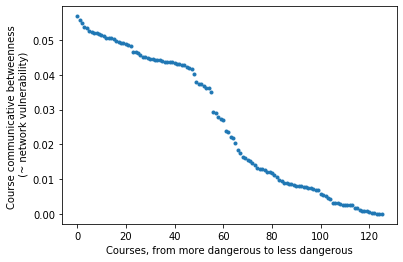

In [13]:
for k,v in cent:
    #print(f"{k:4.4f} - {v}")
    pass

plt.plot([k for k,v in cent], '.');
plt.ylabel('Course communicative betweenness \n (~ network vulnerability)');
plt.xlabel('Courses, from more dangerous to less dangerous');

# SIR model

Refernces:

* Requião da Cunha, B., González-Avella, J. C., & Gonçalves, S. (2015). Fast fragmentation of networks using module-based attacks. PloS one, 10(11), e0142824. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0142824

In [20]:
# Now remove red nodes, but make edges weihted (count how many courses connect any two students).
# The best data structure here is probably a dict of dicts.

def bipartite_to_weighted(gdict, node_type):
    """Converts a bipartite course-student graph into weighted student-student graph."""
    output = {}
    for student,courses in gdict.items():
        if node_type[student] == 1: # If actually student
            multiset = [other for course in courses for other in gdict[course]]
            output[student] = {other : len([token for token in multiset if token==other]) 
                               for other in list(set(multiset))
                               if other != student}
            # Not that list(set()) oparation removes duplicates
    return output

gw = bipartite_to_weighted(gdict, node_type)

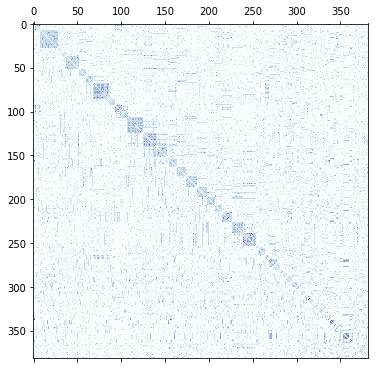

In [43]:
# Visualize

Gvis = nx.Graph()
for node,edges in gw.items():
    Gvis.add_node(node)
for node,edges in gw.items():
    for other,weight in edges.items():
        Gvis.add_edge(node, other, weight=weight)
    
plt.figure(figsize=(6,6));
plt.matshow(nx.adjacency_matrix(Gvis).todense(), cmap=plt.cm.BuPu, fignum=1);

# Stochastic (agent-based) SIR model

In [369]:
# Cellular-automata SIR model

def sir_ca(graph, alpha=None, beta=1):
    """Run SIR, return max penetration (total number of affected nodes) and peak value."""
    n_nodes = len(graph)
    if not alpha:
        average_degree = np.mean([sum([w for other,w in edges.items()]) for node,edges in graph.items()])
        alpha = 1/average_degree
    first = np.random.choice(list(gw.keys()))
    # 0 for succeptible, 1 for sick, 2 for recovered/hospitalized, 3 for "temporary exposed"
    state = {i:0 for i in graph.keys()}
    state[first] = 1
    active = 1
    max_cases = 0
    total_cases = 1
    while active > 0:
        active = 0
        for node in gw.keys():
            if state[node] == 1: # Sick
                for other,weight in graph[node].items():
                    if state[other]==0 and (np.random.uniform() < 1-(1-alpha)**weight):
                        state[other] = 3 # Contagion, but we give it a temporary value of "exposed"
                        total_cases += 1
                if np.random.uniform() < beta:
                    state[node] = 2 # Elimination
        for node in gw.keys():
            #print(str(state[node]), end='')
            if state[node]==3:
                state[node] = 1 # Exposed to sick
            if state[node]==1:
                active += 1
        max_cases = max(max_cases, active)
        #print()
    return (total_cases, max_cases)
        
sir_ca(gw, alpha=1/50)

(2, 1)

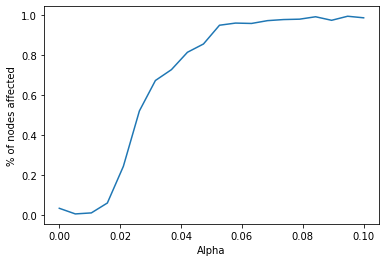

In [382]:
# Find threshold alpha

alphas = np.linspace(0, 0.1, 20)
n_experiments = 100

y = np.zeros(len(alphas))
for i in range(len(alphas)):
    for j in range(n_experiments):
        alpha = alphas[i]
        y[i] += sir_ca(gw, alpha)[0]/n_experiments
plt.plot(alphas,y/len(gw));
plt.xlabel('Alpha');
plt.ylabel('% of nodes affected');

In [397]:
# Delete node utility

def delete_node(graph, target):
    """Delete node from a dict of lists"""
    # We cannot do del without a deep copy, so instead we'll copy all that's needed
    out = {}
    for node,edges in graph.items():
        if node != target:
            out[node] = [other for other in graph[node] if other != target]
    return out

delete_node({0:[0,1,2], 1:[0,2], 2:[0,1]}, 1)

{0: [0, 2], 2: [0]}

Based on this plot, α of about 0.03 or 0.04 would be a good, sensitive value.

Now we have everything we need:
* `gdict`: original graph
* `cent`: an array of tuples, with `[1]` elements representing node names, sorted by betwenness
* `bipartite_to_weighted(gdict, node_type)`: transformer to a weighted graph
* `delete_node(graph, node)`: node deleter by label, working on dict-of-lists
* `sir_ca(graph, alpha=None, beta=1)`: SIR model

In [448]:
# Delete nodes one by one

n_experiments = 5000
to_delete = [None] + [k for v,k in cent[:5]]

share_affected = np.zeros((len(to_delete),2))
peak_value = np.zeros((len(to_delete),2))
for jexperiment in range(2):
    graph = delete_node(gdict, None) # Starting point - a copy of a graph
    for itarget in range(len(to_delete)):
        if jexperiment==0:
            target = to_delete[itarget]
        else:
            if itarget==0:
                target = None
            else:
                target = np.random.choice(list(graph.keys()))
        graph = delete_node(graph, target)
        gw = bipartite_to_weighted(graph, node_type)
        mean_degree = np.mean([np.sum([weight for other,weight in edges.items()]) for node,edges in gw.items()])
        print(f"{itarget} removed, {mean_degree:4.1f} average degree")
        for iexp in range(n_experiments):
            totalcases, maxcases = sir_ca(gw, alpha = 0.04, beta=1)
            share_affected[itarget, jexperiment] += totalcases/n_experiments
            peak_value[itarget, jexperiment] += maxcases/n_experiments

0 removed, 66.7 average degree
1 removed, 65.7 average degree
2 removed, 64.7 average degree
3 removed, 63.7 average degree
4 removed, 62.7 average degree
5 removed, 61.7 average degree
0 removed, 66.7 average degree
1 removed, 65.7 average degree
2 removed, 65.5 average degree
3 removed, 64.5 average degree
4 removed, 64.4 average degree
5 removed, 64.2 average degree


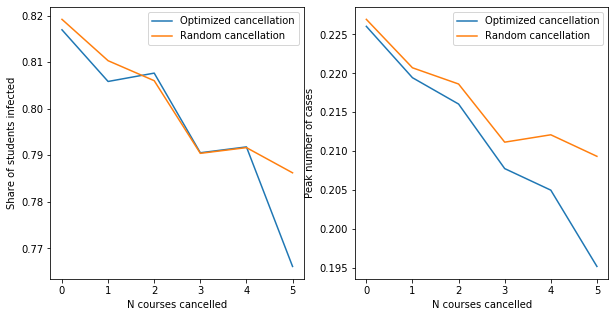

In [449]:
plt.figure(figsize=(10,5))
plt.subplot(121);
plt.plot(share_affected/len(gw));
plt.xlabel('N courses cancelled');
plt.ylabel('Share of students infected');
plt.legend(['Optimized cancellation', 'Random cancellation']);

plt.subplot(122);
plt.plot(peak_value/len(gw));
plt.xlabel('N courses cancelled');
plt.ylabel('Peak number of cases');
plt.legend(['Optimized cancellation', 'Random cancellation']);

**Conclusions:**

1. Stochastic SIR model doesn't really work. Even with 5000 simulations, that take forever, the variability of mean values is about 1-2%, which is pretty comparable with the effect size (also 1-2%). For effects of this size, we should have used differential equations on probabilities.
1. This variability also means that the effects of 1 course cancellation are negligible, compared to the natural variability of disease propagation. We are at mercy of randomness much more than we are at mercy of our network structure.
1. As a corollary, the difference between "clever" course cancellation and random course cancellation is negligible. "Clever" (higher betweenness-centrality) courses tend to have a greater effect, but only just. And note that here I compare their effect with random courses, not even largest courses, even though any sane administrator would probably go for largest courses, if they looked for something to cancel.
1. Finally, to top it off, all this only makes sense if we work in the narrow critical region of α=0.03 to 0.04 (assuming β=1). Above it, everyone gets sick, below - almost everyone stays healthy. But there is no reason to believe that the disease will behave in this critical period in practice (unless we assume that long-term protective measures and changes in behavior somehow adjust to the disease, keeping it in the critical region. Which, given the lag of almost a month between changes in human behavior and associated changes in death rate, seems rather implausible).